# Generate RTM output

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import copy
import seaborn as sns

In [2]:
%matplotlib inline

### Import dataset from CSV (slow)
The next block of instructions read the RTM data saved as a CSV, if the feather file already exists, there is no need to run any of the following. Go directly to the import with feather format

In [55]:
# Path to RTM data (in CSV format)
data_path = 'variable-time_calcite.csv'
complete_dataset = pd.read_csv(data_path, low_memory=False, header=0)                            

In [56]:
complete_dataset.head()

,Time,Domain,NodeID,mineralVolume_coupling,Ca_tr,H_tr,O_tr,Si_tr,charge_tr,C_tr,...,Portlandite,t_Si,si_Cal,t_O_corrected,si_Amor-Sl,Amor-Sl,pe,t_H,water,t_Tr
0,0.0,Concrete,0,0.13728168,0.01933991,0.03863097,0.03876753,0.00003942,-0.00004044,0.00000654,...,0.89,0.00003942,0.0,0.03876753,-5.96966315,0.0,-7.03242379,111.05537785,99.99999987,0.0
1,0.0,Concrete,1,0.13728168,0.01933991,0.03863097,0.03876753,0.00003942,-0.00004044,0.00000654,...,0.89,0.00003942,0.0,0.03876753,-5.96966315,0.0,-7.03233552,111.05537785,99.99999987,0.0
2,0.0,Concrete,2,0.13728168,0.01933991,0.03863097,0.03876753,0.00003942,-0.00004044,0.00000654,...,0.89,0.00003942,0.0,0.03876753,-5.96966315,0.0,-7.03233552,111.05537785,99.99999987,0.0
3,0.0,Concrete,3,0.13728168,0.01933991,0.03863097,0.03876753,0.00003942,-0.00004044,0.00000654,...,0.89,0.00003942,0.0,0.03876753,-5.96966315,0.0,-7.03241567,111.05537785,99.99999987,0.0
4,0.0,Concrete,4,0.13728168,0.01933991,0.03863097,0.03876753,0.00003942,-0.00004044,0.00000654,...,0.89,0.00003942,0.0,0.03876753,-5.96966315,0.0,-7.03241567,111.05537785,99.99999987,0.0


In [57]:
complete_dataset[['d_Portlandite', 'd_Jennite', 'd_Cal']].describe()

,d_Portlandite,d_Jennite,d_Cal
count,1.70374100e+06,1.70374100e+06,1.70374100e+06
mean,-8.14228842e-04,-3.76180506e-04,1.10872510e-03
std,5.74897723e-03,4.00974536e-03,5.32269758e-03
min,-8.34529869e-02,-6.79930856e-02,-1.85297595e-03
25%,0.00000000e+00,-3.98191480e-11,4.07183176e-10
50%,0.00000000e+00,0.00000000e+00,2.12958913e-08
75%,0.00000000e+00,1.81738240e-05,1.97419289e-07
max,0.00000000e+00,4.86433820e-03,4.30033665e-02


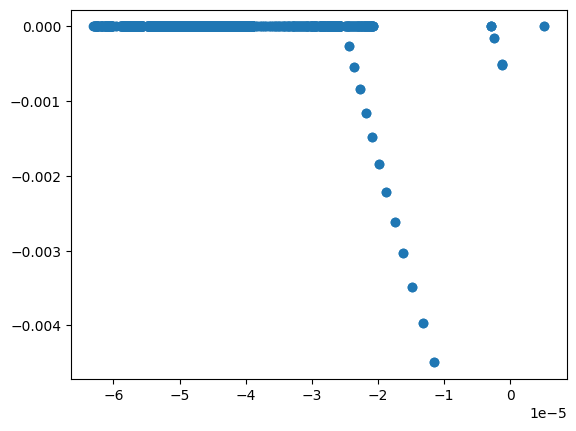

In [58]:
plt.scatter(complete_dataset.loc[complete_dataset['NodeID'] == 5]['d_Jennite'], complete_dataset.loc[complete_dataset['NodeID'] == 5]['d_Portlandite'])

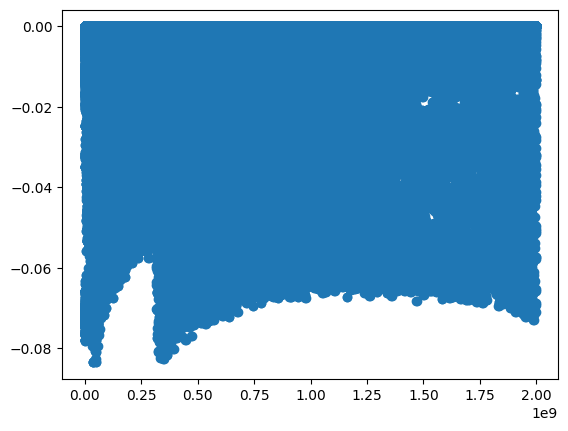

In [59]:
plt.scatter(complete_dataset['Time'], complete_dataset['d_Portlandite'])

In [60]:
# Verify the main stats of the dataset
complete_dataset[['d_Portlandite', 'd_Jennite']].describe()

,d_Portlandite,d_Jennite
count,1.70374100e+06,1.70374100e+06
mean,-8.14228842e-04,-3.76180506e-04
std,5.74897723e-03,4.00974536e-03
min,-8.34529869e-02,-6.79930856e-02
25%,0.00000000e+00,-3.98191480e-11
50%,0.00000000e+00,0.00000000e+00
75%,0.00000000e+00,1.81738240e-05
max,0.00000000e+00,4.86433820e-03


In [61]:
sorted(complete_dataset.columns)

['Amor-Sl',
 'C_tr',
 'Ca_tr',
 'Cal',
 'Domain',
 'H2O',
 'H_tr',
 'Jennite',
 'NodeID',
 'O_tr',
 'Portlandite',
 'Si_tr',
 'Time',
 'Tob-II',
 'Tr_tr',
 'charge_tr',
 'd_Amor-Sl',
 'd_Cal',
 'd_Jennite',
 'd_Portlandite',
 'd_Tob-II',
 'mineralVolume',
 'mineralVolume_coupling',
 'pH',
 'pe',
 'si_Amor-Sl',
 'si_Cal',
 'si_Jennite',
 'si_Portlandite',
 'si_Tob-II',
 't_C',
 't_Ca',
 't_H',
 't_H_corrected',
 't_O',
 't_O_corrected',
 't_Si',
 't_Tr',
 'water',
 'waterMass',
 'waterMassFraction']

In [62]:
complete_dataset[['t_O_corrected', 't_H_corrected']].describe()

,t_O_corrected,t_H_corrected
count,1.70374100e+06,1.70374100e+06
mean,3.20997718e-02,3.18640967e-02
std,1.13297476e-02,1.15137928e-02
min,1.70648991e-03,3.88055244e-04
25%,2.54180789e-02,2.51695495e-02
50%,3.87608348e-02,3.86295799e-02
75%,3.87686118e-02,3.86333052e-02
max,5.56995888e-02,5.56256934e-02


### Process H and O
The totals of O and H include the mass of water, we need to substract the corresponding mass of water to get the transported H and O

In [63]:
gfw_h2o = 1.59994e+01 + 2*1.00795

In [64]:
if 't_H_corrected' not in complete_dataset and 't_O_corrected' not in complete_dataset:
    complete_dataset['t_O'] = complete_dataset.apply(lambda xx: xx['t_O']-1/gfw_h2o*1000, axis=1)
    complete_dataset['t_H'] = complete_dataset.apply(lambda xx: xx['t_H']-2/gfw_h2o*1000, axis=1)
else:  # O and H corrected already in the dataset
    if 't_H' in complete_dataset and 't_O' in complete_dataset:
        complete_dataset.drop(['t_O', 't_H'], axis=1, inplace=True)
    complete_dataset.rename({'t_O_corrected': 't_O', 't_H_corrected': 't_H'}, inplace=True, axis=1)

In [65]:
complete_dataset.sort_index(axis=1).columns

Index(['Amor-Sl', 'C_tr', 'Ca_tr', 'Cal', 'Domain', 'H2O', 'H_tr', 'Jennite',
       'NodeID', 'O_tr', 'Portlandite', 'Si_tr', 'Time', 'Tob-II', 'Tr_tr',
       'charge_tr', 'd_Amor-Sl', 'd_Cal', 'd_Jennite', 'd_Portlandite',
       'd_Tob-II', 'mineralVolume', 'mineralVolume_coupling', 'pH', 'pe',
       'si_Amor-Sl', 'si_Cal', 'si_Jennite', 'si_Portlandite', 'si_Tob-II',
       't_C', 't_Ca', 't_H', 't_O', 't_Si', 't_Tr', 'water', 'waterMass',
       'waterMassFraction'],
      dtype='object')

In [66]:
pd.set_option('display.precision', 8)
complete_dataset[['Time', 'NodeID', 'H_tr', 'O_tr', 't_H', 't_O']].head()

,Time,NodeID,H_tr,O_tr,t_H,t_O
0,0.0,0,0.03863097,0.03876753,0.03863097,0.03876753
1,0.0,1,0.03863097,0.03876753,0.03863097,0.03876753
2,0.0,2,0.03863097,0.03876753,0.03863097,0.03876753
3,0.0,3,0.03863097,0.03876753,0.03863097,0.03876753
4,0.0,4,0.03863097,0.03876753,0.03863097,0.03876753


In [67]:
complete_dataset[['Time', 'NodeID', 'H_tr', 'O_tr', 't_H', 't_O']].loc[[0, 101, 202, 303, 404]]

,Time,NodeID,H_tr,O_tr,t_H,t_O
0,0.0,0,0.03863097,0.03876753,0.03863097,0.03876753
101,0.0,101,0.03863097,0.03876753,0.03863097,0.03876753
202,0.0,202,0.03863097,0.03876753,0.03863097,0.03876753
303,0.0,303,0.03863097,0.03876753,0.03863097,0.03876753
404,0.0,404,0.03863097,0.03876753,0.03863097,0.03876753


In [68]:
complete_dataset[['Time', 'NodeID', 'H_tr', 'O_tr', 't_H', 't_O']].describe()

,Time,NodeID,H_tr,O_tr,t_H,t_O
count,1.70374100e+06,1.70374100e+06,1.70374100e+06,1.70374100e+06,1.70374100e+06,1.70374100e+06
mean,8.26501839e+08,5.39000000e+02,3.18525259e-02,3.20991877e-02,3.18640967e-02,3.20997718e-02
std,6.24153082e+08,3.11480428e+02,1.15020434e-02,1.12987118e-02,1.15137928e-02,1.13297476e-02
min,0.00000000e+00,0.00000000e+00,3.88055244e-04,1.70648991e-03,3.88055244e-04,1.70648991e-03
25%,2.31631920e+08,2.69000000e+02,2.51450628e-02,2.54044872e-02,2.51695495e-02,2.54180789e-02
50%,7.53710400e+08,5.39000000e+02,3.86295345e-02,3.87607862e-02,3.86295799e-02,3.87608348e-02
75%,1.37496960e+09,8.09000000e+02,3.86333085e-02,3.87686136e-02,3.86333052e-02,3.87686118e-02
max,1.99622880e+09,1.07800000e+03,5.56346541e-02,5.57291687e-02,5.56256934e-02,5.56995888e-02


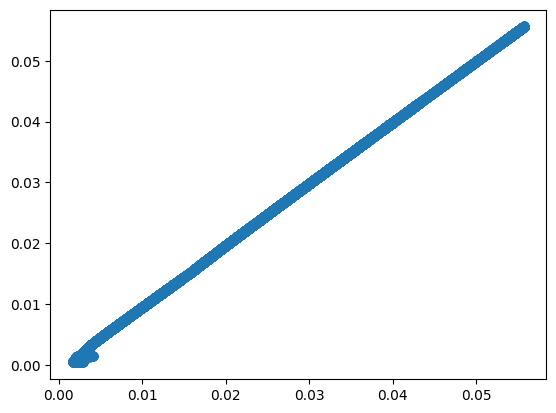

In [69]:
plt.plot(complete_dataset['t_O'], complete_dataset['t_H'], linestyle='none', marker='o')

### Statistics

In [70]:
# Verify the main stats of the dataset
complete_dataset.describe()

,Time,NodeID,mineralVolume_coupling,Ca_tr,H_tr,O_tr,Si_tr,charge_tr,C_tr,Tr_tr,...,d_Jennite,Portlandite,t_Si,si_Cal,t_O,si_Amor-Sl,Amor-Sl,pe,water,t_Tr
count,1.70374100e+06,1.70374100e+06,1.70374100e+06,1.70374100e+06,1.70374100e+06,1.70374100e+06,1.70374100e+06,1.70374100e+06,1.70374100e+06,1.70374100e+06,...,1.70374100e+06,1.70374100e+06,1.70374100e+06,1.70374100e+06,1.70374100e+06,1.70374100e+06,1703741.0,1.70374100e+06,1.70374100e+06,1.70374100e+06
mean,8.26501839e+08,5.39000000e+02,1.37702138e-01,1.59765965e-02,3.18525259e-02,3.20991877e-02,7.99082681e-05,-2.79138744e-05,1.40126277e-05,3.20615911e-03,...,-3.76180506e-04,5.61508613e-01,7.99454809e-05,-5.50051605e-16,3.20997718e-02,-5.46107956e+00,0.0,-8.33065517e+00,1.00000020e+02,3.20149978e-03
std,6.24153082e+08,3.11480428e+02,7.15236063e-02,5.71398905e-03,1.15020434e-02,1.12987118e-02,9.26399824e-05,1.30681719e-05,4.03544764e-05,3.18155496e-03,...,4.00974536e-03,4.25157652e-01,9.41800438e-05,1.30177734e-13,1.13297476e-02,9.50291045e-01,0.0,5.56162166e+00,9.98436539e-05,3.18052238e-03
min,0.00000000e+00,0.00000000e+00,4.13912190e-02,2.14768450e-04,3.88055244e-04,1.70648991e-03,2.18746318e-05,-5.80176156e-05,-9.61446638e-06,-2.20534831e-05,...,-6.79930856e-02,0.00000000e+00,2.18746318e-05,-4.10977918e-11,1.70648991e-03,-6.59486505e+00,0.0,-1.10972860e+01,9.99999279e+01,0.00000000e+00
25%,2.31631920e+08,2.69000000e+02,1.09349986e-01,1.26415002e-02,2.51450628e-02,2.54044872e-02,3.94167416e-05,-4.03624930e-05,6.53867927e-06,3.58671936e-05,...,-3.98191480e-11,0.00000000e+00,3.94167507e-05,0.00000000e+00,2.54180789e-02,-5.96972732e+00,0.0,-1.08377903e+01,9.99999993e+01,3.49611633e-05
50%,7.53710400e+08,5.39000000e+02,1.37281684e-01,1.93399149e-02,3.86295345e-02,3.87607862e-02,3.94280054e-05,-3.14372101e-05,7.66441590e-06,2.30419730e-03,...,0.00000000e+00,8.90000000e-01,3.94279564e-05,0.00000000e+00,3.87608348e-02,-5.96946780e+00,0.0,-1.06285257e+01,1.00000000e+02,2.29465903e-03
75%,1.37496960e+09,8.09000000e+02,1.37281817e-01,1.93416335e-02,3.86333085e-02,3.87686136e-02,8.17688460e-05,-1.64975107e-05,9.29233330e-06,5.99089321e-03,...,1.81738240e-05,8.90000000e-01,8.12545773e-05,0.00000000e+00,3.87686118e-02,-5.21474142e+00,0.0,-9.91884712e+00,1.00000000e+02,5.98417633e-03
max,1.99622880e+09,1.07800000e+03,1.02127873e+00,2.78273773e-02,5.56346541e-02,5.57291687e-02,1.31365647e-03,-1.88319627e-06,5.90698674e-04,9.64637263e-03,...,4.86433820e-03,8.90000000e-01,1.31365647e-03,4.33431069e-13,5.56995888e-02,-4.10582974e-01,0.0,7.32498881e+00,1.00000900e+02,9.64633907e-03


### Fix the transported concentration after and before the chemical step

In [71]:
complete_dataset[['Time', 'NodeID', 'H_tr', 'O_tr', 't_H', 't_O']].loc[[0, 101, 202, 303, 404]]

,Time,NodeID,H_tr,O_tr,t_H,t_O
0,0.0,0,0.03863097,0.03876753,0.03863097,0.03876753
101,0.0,101,0.03863097,0.03876753,0.03863097,0.03876753
202,0.0,202,0.03863097,0.03876753,0.03863097,0.03876753
303,0.0,303,0.03863097,0.03876753,0.03863097,0.03876753
404,0.0,404,0.03863097,0.03876753,0.03863097,0.03876753


In [72]:
# Fix the transported concentration after and before the chemical steper of rows at time 0
n_rows = complete_dataset.groupby('Time').size()[0]
# During the first time step iCP writes the solution at 3 different times, we only care about the last 2
n_rows = n_rows//3
complete_dataset.drop(np.arange(0, n_rows), axis=0, inplace=True)
complete_dataset.reset_index(drop=True, inplace=True)

In [73]:
complete_dataset[['Time', 'NodeID', 'H_tr', 'O_tr', 't_H', 't_O']].loc[[0, 101, 202, 303, 404]]

,Time,NodeID,H_tr,O_tr,t_H,t_O
0,0.0,0,0.03868303,0.03881978,0.03863097,0.03876753
101,0.0,101,0.03863097,0.03876753,0.03863097,0.03876753
202,0.0,202,0.03863097,0.03876753,0.03863097,0.03876753
303,0.0,303,0.03863097,0.03876753,0.03863097,0.03876753
404,0.0,404,0.03863097,0.03876753,0.03863097,0.03876753


In [74]:
# Number of timesteps (2 snapshots per timestep)
n_steps = len(complete_dataset)//(2*n_rows)

In [75]:
complete_dataset[['Time', 'NodeID', 'H_tr', 'O_tr', 't_H', 't_O']].loc[[0, 101, 202, 303, 404]]

,Time,NodeID,H_tr,O_tr,t_H,t_O
0,0.0,0,0.03868303,0.03881978,0.03863097,0.03876753
101,0.0,101,0.03863097,0.03876753,0.03863097,0.03876753
202,0.0,202,0.03863097,0.03876753,0.03863097,0.03876753
303,0.0,303,0.03863097,0.03876753,0.03863097,0.03876753
404,0.0,404,0.03863097,0.03876753,0.03863097,0.03876753


In [76]:
n_rows

1079

In [77]:
complete_dataset[['Time', 'NodeID', 't_Ca', 'Ca_tr']].iloc[[0, n_rows, 2*n_rows, 3*n_rows]]

,Time,NodeID,t_Ca,Ca_tr
0,0.0,0,0.01933991,0.01936598
1079,0.0,0,0.01936574,0.01936574
2158,63072.0,0,0.01936574,0.01939161
3237,63072.0,0,0.01939137,0.01939137


In [78]:
%%time
# To get the concentration before and after the chemical step, iCP is outputted twice per timestep, 
# we need to merge the two snapshots into one.
# The concentration before the chemical step (*_tr) corresponds to the first snapshot
# They need to be translated to the second snapshot and then the first snapshot can be deleted
# TODO : vectorize
for ii in range(0, n_steps, 2):
    cols_tr_species = complete_dataset.filter(regex=r'^\w+_tr$', axis=1).columns
    complete_dataset.loc[(ii+1)*n_rows:(ii+2)*n_rows-1, cols_tr_species] = complete_dataset.loc[ii*n_rows:(ii+1)*n_rows-1, cols_tr_species].to_numpy()

CPU times: total: 32.1 s
Wall time: 33 s


In [79]:
%%time
# Generate all indices to be dropped
indices_to_drop = [i for ii in range(0, n_steps*2, 2) for i in range(ii*n_rows, (ii+1)*n_rows)]
# Drop the rows
complete_dataset.drop(complete_dataset.index[indices_to_drop], inplace=True)
complete_dataset.reset_index(drop=True, inplace=True)

CPU times: total: 469 ms
Wall time: 585 ms


In [80]:
#complete_dataset[['Time', 'NodeID', 't_C', 'C_tr']].iloc[[0, n_rows, 2*n_rows, 3*n_rows, 4*n_rows]]

In [81]:
# Drop useless variables for Case 1 (Fe etc.)
#complete_dataset.drop(['d_Epidote', 'd_Anhydrite', 't_S(6)', 'S_tr', 'si_Epidote', 
#                       'si_Anhydrite', 'Anhydrite', 'Epidote'], inplace=True, axis=1)

In [82]:
sorted(complete_dataset.columns)

['Amor-Sl',
 'C_tr',
 'Ca_tr',
 'Cal',
 'Domain',
 'H2O',
 'H_tr',
 'Jennite',
 'NodeID',
 'O_tr',
 'Portlandite',
 'Si_tr',
 'Time',
 'Tob-II',
 'Tr_tr',
 'charge_tr',
 'd_Amor-Sl',
 'd_Cal',
 'd_Jennite',
 'd_Portlandite',
 'd_Tob-II',
 'mineralVolume',
 'mineralVolume_coupling',
 'pH',
 'pe',
 'si_Amor-Sl',
 'si_Cal',
 'si_Jennite',
 'si_Portlandite',
 'si_Tob-II',
 't_C',
 't_Ca',
 't_H',
 't_O',
 't_Si',
 't_Tr',
 'water',
 'waterMass',
 'waterMassFraction']

In [83]:
# Verify if there are any import issues
complete_dataset.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851331 entries, 0 to 851330
Data columns (total 39 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Time                    851331 non-null  float64
 1   Domain                  851331 non-null  object 
 2   NodeID                  851331 non-null  int64  
 3   mineralVolume_coupling  851331 non-null  float64
 4   Ca_tr                   851331 non-null  float64
 5   H_tr                    851331 non-null  float64
 6   O_tr                    851331 non-null  float64
 7   Si_tr                   851331 non-null  float64
 8   charge_tr               851331 non-null  float64
 9   C_tr                    851331 non-null  float64
 10  Tr_tr                   851331 non-null  float64
 11  waterMass               851331 non-null  float64
 12  si_Portlandite          851331 non-null  float64
 13  t_C                     851331 non-null  float64
 14  t_H                 

In [84]:
complete_dataset.isnull().sum() * 100 / len(complete_dataset)

Time                      0.0
Domain                    0.0
NodeID                    0.0
mineralVolume_coupling    0.0
Ca_tr                     0.0
H_tr                      0.0
O_tr                      0.0
Si_tr                     0.0
charge_tr                 0.0
C_tr                      0.0
Tr_tr                     0.0
waterMass                 0.0
si_Portlandite            0.0
t_C                       0.0
t_H                       0.0
H2O                       0.0
Jennite                   0.0
d_Tob-II                  0.0
mineralVolume             0.0
Tob-II                    0.0
d_Portlandite             0.0
d_Amor-Sl                 0.0
t_Ca                      0.0
pH                        0.0
waterMassFraction         0.0
si_Tob-II                 0.0
d_Cal                     0.0
si_Jennite                0.0
Cal                       0.0
d_Jennite                 0.0
Portlandite               0.0
t_Si                      0.0
si_Cal                    0.0
t_O       

## Clean up potential negative concentrations

In [85]:
cols = complete_dataset.filter(regex=r'^(\w+_tr|t_\w+)').drop(['charge_tr'], axis=1).columns
rows_dropped_index = complete_dataset[(complete_dataset[cols] < 0).any(axis=1)].index
print(f'{len(rows_dropped_index)} rows to be dropped due to negative concentrations')

2154 rows to be dropped due to negative concentrations


In [86]:
complete_dataset.drop(rows_dropped_index, inplace=True)
complete_dataset.reset_index(inplace=True, drop=True)

## Subsampling

In [87]:
# Fraction of the subsample of the complete dataset
n_samples = len(complete_dataset)
rstate = 42

In [88]:
sampled_dataset = complete_dataset.sample(n=n_samples, random_state=rstate, ignore_index=True)
sampled_dataset.describe()

,Time,NodeID,mineralVolume_coupling,Ca_tr,H_tr,O_tr,Si_tr,charge_tr,C_tr,Tr_tr,...,d_Jennite,Portlandite,t_Si,si_Cal,t_O,si_Amor-Sl,Amor-Sl,pe,water,t_Tr
count,8.49177000e+05,849177.00000000,849177.00000000,849177.00000000,849177.00000000,849177.00000000,849177.00000000,849177.00000000,849177.00000000,8.49177000e+05,...,8.49177000e+05,849177.00000000,849177.00000000,8.49177000e+05,849177.00000000,849177.00000000,849177.0,849177.00000000,849177.00000000,8.49177000e+05
mean,8.28933751e+08,538.33483479,0.13772152,0.01596784,0.03183504,0.03207934,0.00008017,-0.00002788,0.00001259,3.21439893e-03,...,-3.76835529e-04,0.56040382,0.00008017,-5.52269071e-16,0.03207252,-5.45875283,0.0,-8.35655849,100.00002014,3.21439849e-03
std,6.23596137e+08,311.30556841,0.07171366,0.00572376,0.01152142,0.01132911,0.00009453,0.00001307,0.00003148,3.18179845e-03,...,4.01355668e-03,0.42545550,0.00009463,1.30383610e-13,0.01134795,0.95261270,0.0,5.53908211,0.00010002,3.18179803e-03
min,0.00000000e+00,0.00000000,0.04139122,0.00021477,0.00038806,0.00170649,0.00002187,-0.00005802,0.00000024,3.69674725e-36,...,-6.79930856e-02,0.00000000,0.00002187,-4.10977918e-11,0.00170649,-6.59486505,0.0,-11.09728598,99.99993581,9.99999990e-15
25%,2.34470160e+08,269.00000000,0.10933657,0.01261779,0.02509688,0.02536969,0.00003942,-0.00004035,0.00000654,3.87976241e-05,...,-3.99889011e-11,0.00000000,0.00003942,0.00000000e+00,0.02532485,-5.96972786,0.0,-10.83816931,99.99999927,3.87976241e-05
50%,7.56864000e+08,538.00000000,0.13728168,0.01933991,0.03862944,0.03876066,0.00003943,-0.00003137,0.00000770,2.32153251e-03,...,0.00000000e+00,0.89000000,0.00003943,0.00000000e+00,0.03876066,-5.96946074,0.0,-10.63043293,100.00000000,2.32153251e-03
75%,1.37812320e+09,808.00000000,0.13728182,0.01934164,0.03863332,0.03876862,0.00008206,-0.00001646,0.00000935,6.00135367e-03,...,1.84985166e-05,0.89000000,0.00008179,0.00000000e+00,0.03876862,-5.20803392,0.0,-9.93390270,100.00000000,6.00135367e-03
max,1.99622880e+09,1078.00000000,1.02127873,0.02781619,0.05562569,0.05569959,0.00131366,-0.00000188,0.00038673,9.64633907e-03,...,4.86433820e-03,0.89000000,0.00131366,4.33431069e-13,0.05569959,-0.41058297,0.0,7.32498881,100.00090041,9.64633907e-03


In [89]:
sampled_dataset.columns

Index(['Time', 'Domain', 'NodeID', 'mineralVolume_coupling', 'Ca_tr', 'H_tr',
       'O_tr', 'Si_tr', 'charge_tr', 'C_tr', 'Tr_tr', 'waterMass',
       'si_Portlandite', 't_C', 't_H', 'H2O', 'Jennite', 'd_Tob-II',
       'mineralVolume', 'Tob-II', 'd_Portlandite', 'd_Amor-Sl', 't_Ca', 'pH',
       'waterMassFraction', 'si_Tob-II', 'd_Cal', 'si_Jennite', 'Cal',
       'd_Jennite', 'Portlandite', 't_Si', 'si_Cal', 't_O', 'si_Amor-Sl',
       'Amor-Sl', 'pe', 'water', 't_Tr'],
      dtype='object')

In [90]:
# Compare sampled and complete datasets for the following variables
variables = ['pH', 't_Ca', 'Portlandite']

In [91]:
alpha_dict = {'sampled': 0.8, 'complete': 0.2}
plot_df = pd.concat([sampled_dataset[variables].assign(hue='sampled'), 
                        complete_dataset[variables].assign(hue='complete')])

In [92]:
#sns.pairplot(plot_df, hue='hue', 
#             plot_kws={'alpha': [alpha_dict.get(x, 1) for x in plot_df.hue]}, markers=['o', 's'])

## Exporing inputs and outputs

In [93]:
# Select the inputs
input_dataset = sampled_dataset.filter(regex='\w+_tr|temperature').sort_index(axis=1)
input_dataset.drop('charge_tr', axis=1, inplace=True)
input_dataset.columns

Index(['C_tr', 'Ca_tr', 'H_tr', 'O_tr', 'Si_tr', 'Tr_tr'], dtype='object')

In [94]:
# Select the outputs
output_dataset = sampled_dataset.filter(regex=r'pH|t_\w+|d_\w+|log_gamma_*|si_*|ionic_strength|density|^water$').sort_index(axis=1)
output_dataset.columns

Index(['d_Amor-Sl', 'd_Cal', 'd_Jennite', 'd_Portlandite', 'd_Tob-II', 'pH',
       'si_Amor-Sl', 'si_Cal', 'si_Jennite', 'si_Portlandite', 'si_Tob-II',
       't_C', 't_Ca', 't_H', 't_O', 't_Si', 't_Tr', 'water'],
      dtype='object')

In [95]:
# Export to feather format which is much faster to load
input_dataset.to_feather('input_dataset_rtm_case_0')

In [96]:
output_dataset.to_feather('output_dataset_rtm_case_0')

In [97]:
complete_dataset['t_Ca'].describe()

count    849177.00000000
mean          0.01596862
std           0.00572906
min           0.00021477
25%           0.01260745
50%           0.01933991
75%           0.01934164
max           0.02781619
Name: t_Ca, dtype: float64

In [98]:
complete_dataset

,Time,Domain,NodeID,mineralVolume_coupling,Ca_tr,H_tr,O_tr,Si_tr,charge_tr,C_tr,...,d_Jennite,Portlandite,t_Si,si_Cal,t_O,si_Amor-Sl,Amor-Sl,pe,water,t_Tr
0,0.0,Concrete,4,0.13728135,0.01933226,0.03861568,0.03875219,0.00003940,-0.00004043,0.00000653,...,-0.00000412,0.89,0.00003944,0.0,0.03875238,-5.96897863,0.0,5.53703766,100.00000010,9.99999999e-15
1,0.0,Concrete,5,0.13728145,0.01933443,0.03862002,0.03875654,0.00003941,-0.00004043,0.00000654,...,-0.00000295,0.89,0.00003944,0.0,0.03875668,-5.96917286,0.0,5.47673753,100.00000007,9.99999999e-15
2,0.0,Concrete,6,0.13728178,0.01934207,0.03863527,0.03877185,0.00003942,-0.00004045,0.00000654,...,0.00000116,0.89,0.00003941,0.0,0.03877180,-5.96985580,0.0,5.49965472,99.99999997,1.00000000e-14
3,0.0,Concrete,8,0.13728168,0.01933983,0.03863080,0.03876736,0.00003942,-0.00004044,0.00000654,...,-0.00000005,0.89,0.00003942,0.0,0.03876736,-5.96965540,0.0,5.54573906,100.00000000,1.00000000e-14
4,0.0,Concrete,9,0.13728166,0.01933926,0.03862965,0.03876621,0.00003942,-0.00004044,0.00000654,...,-0.00000035,0.89,0.00003942,0.0,0.03876623,-5.96960428,0.0,5.51096667,100.00000001,1.00000000e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849172,1996228800.0,Concrete,1074,0.11416597,0.00082941,0.00153234,0.00286401,0.00062189,-0.00000265,0.00001531,...,0.00000000,0.00,0.00062189,0.0,0.00286401,-1.74964817,0.0,-8.88294022,99.99995553,9.45518620e-03
849173,1996228800.0,Concrete,1075,1.02127873,0.00024640,0.00045334,0.00285605,0.00086581,-0.00000189,0.00032780,...,0.00000000,0.00,0.00086581,0.0,0.00285605,-0.42142052,0.0,-6.41254073,100.00045251,9.64518061e-03
849174,1996228800.0,Concrete,1076,0.08734855,0.00046241,0.00088472,0.00286420,0.00095318,-0.00000220,0.00002908,...,0.00000000,0.00,0.00095318,0.0,0.00286420,-0.88218706,0.0,-7.91454963,100.00007832,9.56749383e-03
849175,1996228800.0,Concrete,1077,1.00528884,0.00024530,0.00045063,0.00285323,0.00087221,-0.00000189,0.00032103,...,0.00000000,0.00,0.00087221,0.0,0.00285323,-0.42002611,0.0,-6.42293102,100.00046707,9.64520046e-03


In [99]:
complete_dataset.to_csv('processed_calcite.csv')